**Step 1: Setting up the environment**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import time
import os
import shutil
import joblib
import warnings
from datetime import datetime

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)
# MLflow setup
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

C:\Users\lvand\PycharmProjects\fraud-detection-mlops\.venv\Lib\site-packages\mlflow\utils\requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251


In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Create directory structure
PROJECT_ROOT = Path(r"C:\Users\lvand\PycharmProjects\fraud-detection-mlops").resolve()

# Kaggle location
RAW_DIR = Path(r"C:\Users\lvand\.cache\kagglehub\datasets\prajwaldongre\loan-application-and-transaction-fraud-detection\versions\1")

# Project folders
DATA_DIR        = PROJECT_ROOT / "data"
MONTHLY_DIR     = DATA_DIR / "monthly"
MODELS_DIR      = PROJECT_ROOT / "models"
CURRENT_DIR     = MODELS_DIR / "current"
ARCHIVE_DIR     = MODELS_DIR / "archive"
METRICS_DIR     = PROJECT_ROOT / "metrics"
ARTIFACTS_DIR   = METRICS_DIR / "artifacts"
MLRUNS_DIR      = PROJECT_ROOT / "mlruns"

for d in [MONTHLY_DIR, CURRENT_DIR, ARCHIVE_DIR, ARTIFACTS_DIR, MLRUNS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

mlflow.set_tracking_uri(MLRUNS_DIR.as_uri())
mlflow.set_experiment("fraud_detection_baseline")

def raw_path(*parts) -> Path:
    return RAW_DIR.joinpath(*parts)

def month_path(month: str, *parts) -> Path:
    return MONTHLY_DIR.joinpath(month, *parts)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RAW_DIR:", RAW_DIR)
print("MONTHLY_DIR:", MONTHLY_DIR)
print("MLflow tracking URI:", mlflow.get_tracking_uri())


PROJECT_ROOT: C:\Users\lvand\PycharmProjects\fraud-detection-mlops
RAW_DIR: C:\Users\lvand\.cache\kagglehub\datasets\prajwaldongre\loan-application-and-transaction-fraud-detection\versions\1
MONTHLY_DIR: C:\Users\lvand\PycharmProjects\fraud-detection-mlops\data\monthly
MLflow tracking URI: file:///C:/Users/lvand/PycharmProjects/fraud-detection-mlops/mlruns


In [4]:
# Setup MLflow
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("fraud_detection_baseline")

<Experiment: artifact_location='file:///C:/Users/lvand/PycharmProjects/fraud-detection-mlops/notebooks/mlruns/655334123622831845', creation_time=1755957397855, experiment_id='655334123622831845', last_update_time=1755957397855, lifecycle_stage='active', name='fraud_detection_baseline', tags={}>

**Step 2: Combine training data for month 1-3**

In [5]:
def load_monthly_data(months):
    """Load and combine data from specified months"""
    all_loans = []
    all_transactions = []

    for month in months:
        month_str = f"{month:02d}"
        month_path = Path('data/monthly') / month_str

        # Load monthly data
        loans = pd.read_csv(month_path / 'loan_applications.csv')
        transactions = pd.read_csv(month_path / 'transactions.csv')

        # Add month identifier
        loans['data_month'] = month
        transactions['data_month'] = month

        all_loans.append(loans)
        all_transactions.append(transactions)

        print(f"Month {month_str}: {len(loans)} loans, {loans['fraud_flag'].mean():.3f} fraud rate")

    combined_loans = pd.concat(all_loans, ignore_index=True)
    combined_transactions = pd.concat(all_transactions, ignore_index=True)

    return combined_loans, combined_transactions

# Load training data (months 01-03)
print("Loading training data from months 01-03...")
train_loans, train_transactions = load_monthly_data([1, 2, 3])

print(f"\nTraining set summary:")
print(f"Total loan applications: {len(train_loans)}")
print(f"Total transactions: {len(train_transactions)}")
print(f"Overall fraud rate (loans): {train_loans['fraud_flag'].mean():.3f}")
print(f"Fraud distribution: {train_loans['fraud_flag'].value_counts().to_dict()}")

# Load validation data (month 04)
print(f"\nLoading validation data from month 04...")
val_loans, val_transactions = load_monthly_data([4])

print(f"Validation set summary:")
print(f"Loan applications: {len(val_loans)}")
print(f"Fraud rate: {val_loans['fraud_flag'].mean():.3f}")

Loading training data from months 01-03...
Month 01: 4167 loans, 0.018 fraud rate
Month 02: 4167 loans, 0.020 fraud rate
Month 03: 4167 loans, 0.022 fraud rate

Training set summary:
Total loan applications: 12501
Total transactions: 31291
Overall fraud rate (loans): 0.020
Fraud distribution: {0: 12252, 1: 249}

Loading validation data from month 04...
Month 04: 4167 loans, 0.018 fraud rate
Validation set summary:
Loan applications: 4167
Fraud rate: 0.018


**Step 3: Feature engineering and selection**

In [6]:
def engineer_features(loans_df, transactions_df):
    """Create features for fraud detection model"""

    #  Loan application features
    features_df = loans_df.copy()

    # Transaction aggregations per customer
    trans_agg = transactions_df.groupby('customer_id').agg({
        'transaction_amount': ['count', 'sum', 'mean', 'std', 'max'],
        'fraud_flag': 'sum'  # Number of fraudulent transactions
    }).round(3)

    # Flatten column names
    trans_agg.columns = [f'trans_{col[0]}_{col[1]}' if col[1] else f'trans_{col[0]}'
                        for col in trans_agg.columns]
    trans_agg = trans_agg.fillna(0)

    # Merge with loan data
    features_df = features_df.merge(trans_agg, on='customer_id', how='left')

    # Fill missing transaction data (customers with no transactions)
    trans_cols = [col for col in features_df.columns if col.startswith('trans_')]
    features_df[trans_cols] = features_df[trans_cols].fillna(0)

    return features_df

# Engineer features
print("Engineering features...")
train_features = engineer_features(train_loans, train_transactions)
val_features = engineer_features(val_loans, val_transactions)

print(f"Features engineered. Shape: {train_features.shape}")
print(f"Available columns: {train_features.columns.tolist()}")

# Select top features based on correlation analysis and business logic
selected_features = [
    # Top correlated features
    'debt_to_income_ratio',          # Highest correlation (0.0056)
    'applicant_age',                 # Second highest (0.0048)
    'cibil_score',                   # Credit score
    'loan_amount_requested',         # Loan amount
    'monthly_income',                # Income
    'existing_emis_monthly',         # Existing EMIs
    'interest_rate_offered',         # Interest rate
    'loan_tenure_months',            # Loan tenure
    'number_of_dependents',          # Dependents

    # Transaction aggregations
    'trans_transaction_amount_count',  # Number of transactions
    'trans_transaction_amount_sum',    # Total transaction volume
    'trans_transaction_amount_mean',   # Average transaction size
    'trans_transaction_amount_std',    # Transaction variability
    'trans_fraud_flag_sum'            # Number of fraudulent transactions
]

print(f"\nSelected features ({len(selected_features)}):")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")

Engineering features...
Features engineered. Shape: (12501, 28)
Available columns: ['application_id', 'customer_id', 'application_date', 'loan_type', 'loan_amount_requested', 'loan_tenure_months', 'interest_rate_offered', 'purpose_of_loan', 'employment_status', 'monthly_income', 'cibil_score', 'existing_emis_monthly', 'debt_to_income_ratio', 'property_ownership_status', 'residential_address', 'applicant_age', 'gender', 'number_of_dependents', 'loan_status', 'fraud_flag', 'fraud_type', 'data_month', 'trans_transaction_amount_count', 'trans_transaction_amount_sum', 'trans_transaction_amount_mean', 'trans_transaction_amount_std', 'trans_transaction_amount_max', 'trans_fraud_flag_sum']

Selected features (14):
 1. debt_to_income_ratio
 2. applicant_age
 3. cibil_score
 4. loan_amount_requested
 5. monthly_income
 6. existing_emis_monthly
 7. interest_rate_offered
 8. loan_tenure_months
 9. number_of_dependents
10. trans_transaction_amount_count
11. trans_transaction_amount_sum
12. trans_tr

**Step 4: Data preprocessing**

In [7]:
# Preprocess data

def preprocess_data(df: pd.DataFrame, feature_list, *, fit_scaler: bool, scaler: StandardScaler | None = None):
    """Select features, mean-impute, scale. Returns (X_scaled, y, scaler_or_None, used_features).
    Preserve order and drop any missing columns"""

    used = [f for f in feature_list if f in df.columns]
    dropped = [f for f in feature_list if f not in df.columns]
    if dropped:
        print(f"Note: dropping missing features: {dropped}")

    X = df[used].apply(pd.to_numeric, errors="coerce")
    y = df["fraud_flag"].astype(int)

    # mean impute (numeric)
    X = X.fillna(X.mean(numeric_only=True))

    if fit_scaler:
        scaler = StandardScaler()
        Xs = scaler.fit_transform(X)
        return Xs, y, scaler, used
    else:
        if scaler is None:
            raise ValueError("When fit_scaler=False, provide a fitted 'scaler'.")
        Xs = scaler.transform(X)
        return Xs, y, None, used

print("Preprocessing training data…")
X_train, y_train, scaler, final_features = preprocess_data(
    train_features, selected_features, fit_scaler=True
)

print("Preprocessing validation data…")
X_val, y_val, _, _ = preprocess_data(
    val_features, final_features, fit_scaler=False, scaler=scaler
)

# For downstream compatibility
encoders = {}

print("\nPreprocessing complete:")
print(f"Training set:   {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Features used:  {len(final_features)}")
print(f"Final features: {final_features}")


Preprocessing training data…
Preprocessing validation data…

Preprocessing complete:
Training set:   (12501, 14)
Validation set: (4167, 14)
Features used:  14
Final features: ['debt_to_income_ratio', 'applicant_age', 'cibil_score', 'loan_amount_requested', 'monthly_income', 'existing_emis_monthly', 'interest_rate_offered', 'loan_tenure_months', 'number_of_dependents', 'trans_transaction_amount_count', 'trans_transaction_amount_sum', 'trans_transaction_amount_mean', 'trans_transaction_amount_std', 'trans_fraud_flag_sum']


**Step 5: Train baseline model**

In [8]:
# Start MLflow run
with mlflow.start_run(run_name=f"baseline_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):

    print("Training baseline fraud detection model...")

    # Initialize model with balanced class weights (as specified in brief)
    model = LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000
    )

    # Train model
    model.fit(X_train, y_train)

    # Log model parameters
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("n_features", len(final_features))
    mlflow.log_param("train_months", "01-03")
    mlflow.log_param("val_month", "04")
    mlflow.log_param("train_samples", len(X_train))
    mlflow.log_param("val_samples", len(X_val))

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]

    print("Model training completed!")
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")

Training baseline fraud detection model...
Model training completed!
Training samples: 12501
Validation samples: 4167


**Step 6: Calculate and log performance metrics**

In [9]:
def calculate_metrics(y_true, y_pred, y_proba, dataset_name):
    """Calculate comprehensive performance metrics"""

    metrics = {
        f'{dataset_name}_accuracy': accuracy_score(y_true, y_pred),
        f'{dataset_name}_precision': precision_score(y_true, y_pred),
        f'{dataset_name}_recall': recall_score(y_true, y_pred),
        f'{dataset_name}_f1': f1_score(y_true, y_pred),
        f'{dataset_name}_auc': roc_auc_score(y_true, y_proba)
    }

    return metrics

# Calculate metrics for both sets
print("Calculating performance metrics...")

train_metrics = calculate_metrics(y_train, y_train_pred, y_train_proba, 'train')
val_metrics = calculate_metrics(y_val, y_val_pred, y_val_proba, 'val')

# Combine all metrics
all_metrics = {**train_metrics, **val_metrics}

# Log metrics to MLflow
for metric_name, metric_value in all_metrics.items():
    mlflow.log_metric(metric_name, metric_value)

# Print results
print("\n" + "="*50)
print("MODEL PERFORMANCE RESULTS")
print("="*50)

print(f"\nTRAINING SET PERFORMANCE:")
print(f"  Accuracy:  {train_metrics['train_accuracy']:.4f}")
print(f"  Precision: {train_metrics['train_precision']:.4f}")
print(f"  Recall:    {train_metrics['train_recall']:.4f}")
print(f"  F1-Score:  {train_metrics['train_f1']:.4f}")
print(f"  AUC-ROC:   {train_metrics['train_auc']:.4f}")

print(f"\nVALIDATION SET PERFORMANCE:")
print(f"  Accuracy:  {val_metrics['val_accuracy']:.4f}")
print(f"  Precision: {val_metrics['val_precision']:.4f}")
print(f"  Recall:    {val_metrics['val_recall']:.4f}")
print(f"  F1-Score:  {val_metrics['val_f1']:.4f}")
print(f"  AUC-ROC:   {val_metrics['val_auc']:.4f}")

# Calculate performance difference (overfitting check)
auc_diff = train_metrics['train_auc'] - val_metrics['val_auc']
acc_diff = train_metrics['train_accuracy'] - val_metrics['val_accuracy']

print(f"\nPERFORMACE STABILITY:")
print(f"  AUC difference (train-val):      {auc_diff:.4f}")
print(f"  Accuracy difference (train-val): {acc_diff:.4f}")

if auc_diff < 0.05:
    print("  ✓ Model shows good generalization")
else:
    print("  ⚠ Potential overfitting detected")

Calculating performance metrics...

MODEL PERFORMANCE RESULTS

TRAINING SET PERFORMANCE:
  Accuracy:  0.9207
  Precision: 0.1807
  Recall:    0.8434
  F1-Score:  0.2977
  AUC-ROC:   0.9468

VALIDATION SET PERFORMANCE:
  Accuracy:  0.9203
  Precision: 0.1600
  Recall:    0.7792
  F1-Score:  0.2655
  AUC-ROC:   0.9205

PERFORMACE STABILITY:
  AUC difference (train-val):      0.0263
  Accuracy difference (train-val): 0.0004
  ✓ Model shows good generalization


**Step 7: Save baseline metrics for drift detection**

In [10]:
# Save baseline metrics

baseline_metrics = {
    'accuracy': val_metrics['val_accuracy'],
    'auroc': val_metrics['val_auc'],
    'precision': val_metrics['val_precision'],
    'recall': val_metrics['val_recall'],
    'f1': val_metrics['val_f1'],
    'training_months': '01-03',
    'validation_month': '04',
    'model_type': 'LogisticRegression',
    'timestamp': datetime.now().isoformat(),
    'n_samples_train': len(X_train),
    'n_samples_val': len(X_val)
}

# Save baseline to current model directory
baseline_file = CURRENT_DIR / "baseline_metrics.json"

with open(baseline_file, "w") as f:
    json.dump(baseline_metrics, f, indent=2)

print(f"Baseline accuracy: {baseline_metrics['accuracy']:.4f}")
print(f"Baseline AUROC: {baseline_metrics['auroc']:.4f}")
print(f"Saved to: {baseline_file}")

# Also log to MLflow for tracking
mlflow.log_metric("baseline_accuracy", baseline_metrics['accuracy'])
mlflow.log_metric("baseline_auroc", baseline_metrics['auroc'])

Baseline accuracy: 0.9203
Baseline AUROC: 0.9205
Saved to: C:\Users\lvand\PycharmProjects\fraud-detection-mlops\models\current\baseline_metrics.json


**Step 7: Performance visualizations**

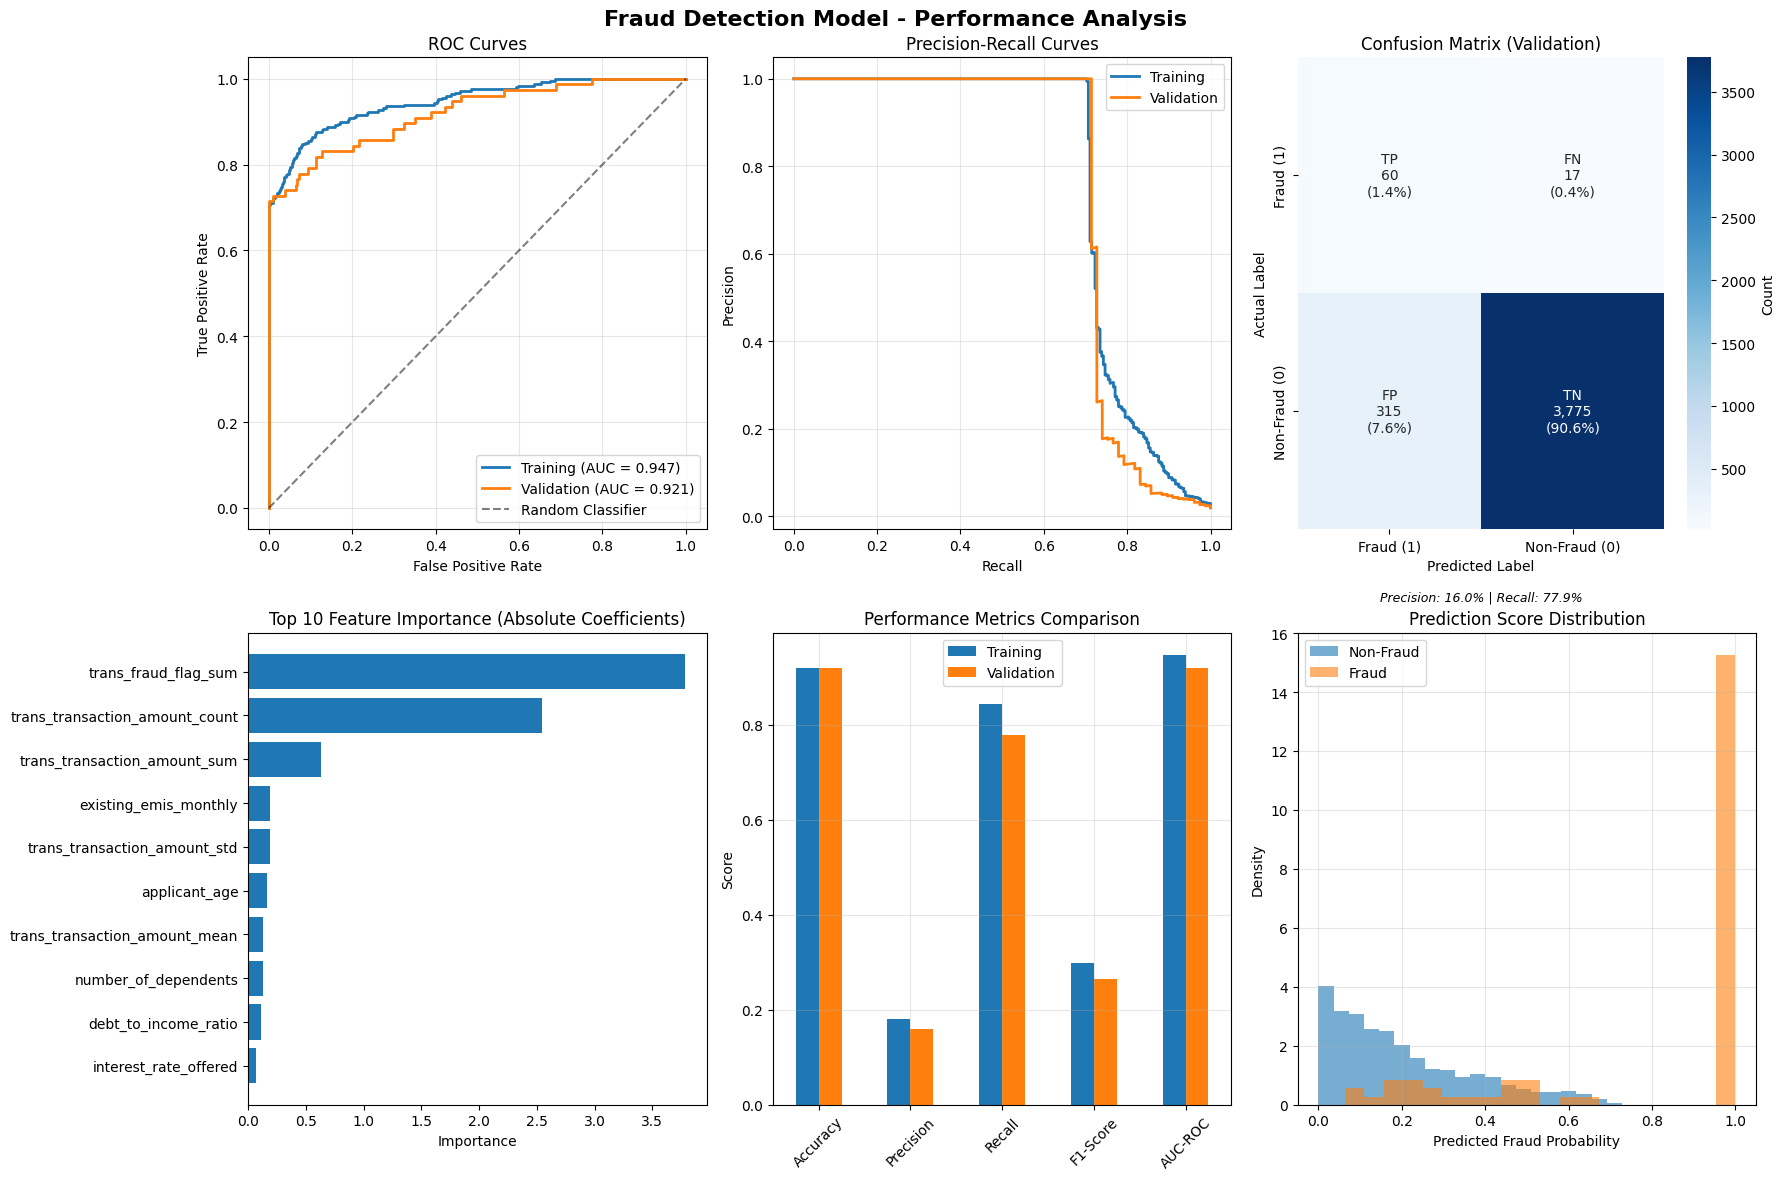

Performance visualizations saved to: C:\Users\lvand\PycharmProjects\fraud-detection-mlops\metrics\artifacts\model_performance_analysis.png


In [11]:
# Set up the plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Create comprehensive performance visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Fraud Detection Model - Performance Analysis', fontsize=16, fontweight='bold')

# 1. ROC Curves
ax1 = axes[0, 0]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)

ax1.plot(fpr_train, tpr_train, label=f'Training (AUC = {train_metrics["train_auc"]:.3f})', linewidth=2)
ax1.plot(fpr_val, tpr_val, label=f'Validation (AUC = {val_metrics["val_auc"]:.3f})', linewidth=2)
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Precision-Recall Curves
ax2 = axes[0, 1]
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_proba)

ax2.plot(recall_train, precision_train, label=f'Training', linewidth=2)
ax2.plot(recall_val, precision_val, label=f'Validation', linewidth=2)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Confusion Matrix
ax3 = axes[0, 2]
cm_val = confusion_matrix(y_val, y_val_pred)

cm_reordered = np.array([[cm_val[1,1], cm_val[1,0]],
                        [cm_val[0,1], cm_val[0,0]]])

# Create abbreviated labels with percentages
cm_labels = np.array([
    [f'TP\n{cm_val[1,1]:,}\n({cm_val[1,1]/len(y_val)*100:.1f}%)',
     f'FN\n{cm_val[1,0]:,}\n({cm_val[1,0]/len(y_val)*100:.1f}%)'],
    [f'FP\n{cm_val[0,1]:,}\n({cm_val[0,1]/len(y_val)*100:.1f}%)',
     f'TN\n{cm_val[0,0]:,}\n({cm_val[0,0]/len(y_val)*100:.1f}%)']
])

# Create the heatmap with reordered matrix
sns.heatmap(cm_reordered, annot=cm_labels, fmt='', ax=ax3, cmap='Blues',
           cbar_kws={'label': 'Count'})
ax3.set_title('Confusion Matrix (Validation)')
ax3.set_xlabel('Predicted Label')
ax3.set_ylabel('Actual Label')
ax3.set_xticklabels(['Fraud (1)', 'Non-Fraud (0)'])
ax3.set_yticklabels(['Fraud (1)', 'Non-Fraud (0)'])

# Add interpretation text
precision = cm_val[1,1]/(cm_val[1,1]+cm_val[0,1])
recall = cm_val[1,1]/(cm_val[1,1]+cm_val[1,0])
interpretation = f'Precision: {precision:.1%} | Recall: {recall:.1%}'
ax3.text(0.5, -0.15, interpretation, transform=ax3.transAxes,
         ha='center', fontsize=9, style='italic')

# 4. Feature Importance
ax4 = axes[1, 0]
feature_importance = abs(model.coef_[0])
importance_df = pd.DataFrame({
    'feature': final_features,
    'importance': feature_importance
}).sort_values('importance', ascending=True).tail(10)

ax4.barh(importance_df['feature'], importance_df['importance'])
ax4.set_title('Top 10 Feature Importance (Absolute Coefficients)')
ax4.set_xlabel('Importance')

# 5. Metrics Comparison
ax5 = axes[1, 1]
metrics_comparison = pd.DataFrame({
    'Training': [train_metrics['train_accuracy'], train_metrics['train_precision'],
                train_metrics['train_recall'], train_metrics['train_f1'], train_metrics['train_auc']],
    'Validation': [val_metrics['val_accuracy'], val_metrics['val_precision'],
                  val_metrics['val_recall'], val_metrics['val_f1'], val_metrics['val_auc']]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'])

metrics_comparison.plot(kind='bar', ax=ax5)
ax5.set_title('Performance Metrics Comparison')
ax5.set_ylabel('Score')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45)
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Prediction Score Distribution
ax6 = axes[1, 2]
ax6.hist(y_val_proba[y_val == 0], bins=20, alpha=0.6, label='Non-Fraud', density=True)
ax6.hist(y_val_proba[y_val == 1], bins=20, alpha=0.6, label='Fraud', density=True)
ax6.set_xlabel('Predicted Fraud Probability')
ax6.set_ylabel('Density')
ax6.set_title('Prediction Score Distribution')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()

# Save the plot
plot_path = ARTIFACTS_DIR / 'model_performance_analysis.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
mlflow.log_artifact(str(plot_path))

plt.show()

print(f"Performance visualizations saved to: {plot_path}")

**Step 9: Save Model**

In [12]:
# Save model

ts = time.strftime("%Y%m%d_%H%M%S")
archive_path = ARCHIVE_DIR / ts
archive_path.mkdir(parents=True, exist_ok=True)

model_metadata = {
    "model_type": "LogisticRegression",
    "training_date": time.strftime("%Y-%m-%dT%H:%M:%S"),
    "training_months": "01-03",
    "validation_month": "04",
    "features": list(final_features),
    "n_features": int(len(final_features)),
    "performance": {
        "validation_accuracy": float(val_metrics["val_accuracy"]),
        "validation_auc": float(val_metrics["val_auc"]),
        "validation_precision": float(val_metrics["val_precision"]),
        "validation_recall": float(val_metrics["val_recall"]),
        "validation_f1": float(val_metrics["val_f1"]),
    },
    "preprocessing": {"scaler_type": "StandardScaler", "encoders": list(encoders.keys())},
}

# write to archive
joblib.dump(model,    archive_path / "model.pkl")
joblib.dump(scaler,   archive_path / "scaler.pkl")
joblib.dump(encoders, archive_path / "encoders.pkl")
(archive_path / "metadata.json").write_text(json.dumps(model_metadata, indent=2))

# refresh "current"
if CURRENT_DIR.exists():
    shutil.rmtree(CURRENT_DIR)
shutil.copytree(archive_path, CURRENT_DIR)

print("Saved current:", CURRENT_DIR.resolve())
print("Archived at:", archive_path.resolve())


Saved current: C:\Users\lvand\PycharmProjects\fraud-detection-mlops\models\current
Archived at: C:\Users\lvand\PycharmProjects\fraud-detection-mlops\models\archive\20250828_183259


**Step 10: Performance history tracking**

In [13]:
# Create performance history entry
performance_entry = {
    'timestamp': datetime.now().isoformat(),
    'month': '04',  # Validation month
    'model_version': ts,
    'data_source': 'validation',
    'accuracy': float(val_metrics['val_accuracy']),
    'auc': float(val_metrics['val_auc']),
    'precision': float(val_metrics['val_precision']),
    'recall': float(val_metrics['val_recall']),
    'f1': float(val_metrics['val_f1']),
    'training_months': '01-03',
    'n_samples': int(len(X_val)),
    'fraud_rate': float(y_val.mean()),
    'drift_detected': False,
    'retrain_triggered': False
}

# Save to performance history
performance_history_file = METRICS_DIR / 'performance_history.csv'

if performance_history_file.exists():
    history_df = pd.read_csv(performance_history_file)
    history_df = pd.concat([history_df, pd.DataFrame([performance_entry])], ignore_index=True)
else:
    history_df = pd.DataFrame([performance_entry])

history_df.to_csv(performance_history_file, index=False)

print(f"Performance history updated:")
print(f"  File: {performance_history_file}")
print(f"  Baseline AUC: {val_metrics['val_auc']:.4f}")
print(f"  Baseline Accuracy: {val_metrics['val_accuracy']:.4f}")

Performance history updated:
  File: C:\Users\lvand\PycharmProjects\fraud-detection-mlops\metrics\performance_history.csv
  Baseline AUC: 0.9205
  Baseline Accuracy: 0.9203


# Summary

In [14]:
print("\n" + "="*60)
print("BASELINE MODEL TRAINING COMPLETE")
print("="*60)

print(f"\nMODEL SUMMARY:")
print(f"  Algorithm: LogisticRegression (class_weight='balanced')")
print(f"  Training Period: Months 01-03 ({len(X_train)} samples)")
print(f"  Validation Period: Month 04 ({len(X_val)} samples)")
print(f"  Features Used: {len(final_features)}")
print(f"  Training Fraud Rate: {y_train.mean():.3f}")
print(f"  Validation Fraud Rate: {y_val.mean():.3f}")

print(f"\nKEY PERFORMANCE METRICS (Validation):")
print(f"  AUC-ROC: {val_metrics['val_auc']:.4f}")
print(f"  Accuracy: {val_metrics['val_accuracy']:.4f}")
print(f"  Precision: {val_metrics['val_precision']:.4f}")
print(f"  Recall: {val_metrics['val_recall']:.4f}")
print(f"  F1-Score: {val_metrics['val_f1']:.4f}")

print(f"\nMODEL ARTIFACTS CREATED:")
print(f"  Trained model: models/current/model.pkl")
print(f"  Feature scaler: models/current/scaler.pkl")
print(f"  Encoders: models/current/encoders.pkl")
print(f"  Metadata: models/current/metadata.json")
print(f"  Performance charts: metrics/artifacts/")
print(f"  MLflow experiment logged")

print(f"\nDRIFT DETECTION BASELINE:")
print(f"  Baseline AUC: {val_metrics['val_auc']:.4f}")
print(f"  Drift Threshold: ±0.05 AUC change")
print(f"  Expected drift in months: 06, 09, 11")


BASELINE MODEL TRAINING COMPLETE

MODEL SUMMARY:
  Algorithm: LogisticRegression (class_weight='balanced')
  Training Period: Months 01-03 (12501 samples)
  Validation Period: Month 04 (4167 samples)
  Features Used: 14
  Training Fraud Rate: 0.020
  Validation Fraud Rate: 0.018

KEY PERFORMANCE METRICS (Validation):
  AUC-ROC: 0.9205
  Accuracy: 0.9203
  Precision: 0.1600
  Recall: 0.7792
  F1-Score: 0.2655

MODEL ARTIFACTS CREATED:
  Trained model: models/current/model.pkl
  Feature scaler: models/current/scaler.pkl
  Encoders: models/current/encoders.pkl
  Metadata: models/current/metadata.json
  Performance charts: metrics/artifacts/
  MLflow experiment logged

DRIFT DETECTION BASELINE:
  Baseline AUC: 0.9205
  Drift Threshold: ±0.05 AUC change
  Expected drift in months: 06, 09, 11
